### Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from ml_utils import load_data


service_account_path = '/home/yusuf/DataScience/dream_games/ybektas20.json'
df = load_data(service_account_path)
df.info()


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [ ]:
from ml_utils import get_X_y
X, y = get_X_y(df)
print(X.shape, y.shape)

categorical_columns = ['country', 'platform', 'network']
one_hot_encoded_columns = ['event_participate']

for col in categorical_columns:
    X = pd.get_dummies(X, columns=[col], prefix=col)
    one_hot_encoded_columns += [c for c in X.columns if c.startswith(col+'_')] 
X.columns

(342519, 20) (342519,)


/home/yusuf/DataScience/dream_games/q3/ml_utils.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['time_spend_rate'] = df['time_spend'] / (df['level_start']+1)
/home/yusuf/DataScience/dream_games/q3/ml_utils.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['success_rate'] = df['level_success'] / (df['level_start'] + 1)
/home/yusuf/DataScience/dream_games/q3/ml_utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Index(['age', 'time_spend', 'level_success', 'event_participate',
       'coin_amount', 'booster_spend', 'shop_open', 'time_spend_rate',
       'success_rate', 'net_coin', 'net_booster', 'net_coin_rate',
       'net_booster_freq', 'booster_spend_ratio', 'coin_spend_ratio',
       'shop_open_frequency', 'event_participate_frequency',
       'country_Amaryllis', 'country_Azurelia', 'country_Brighthaven',
       'country_Crystalbrook', 'country_Eldoria', 'country_Emberlyn',
       'country_Floravia', 'country_Frostford', 'country_Gleamwood',
       'country_Glimmerdell', 'country_Luminara', 'country_Moonvale',
       'country_Rosewyn', 'country_Seraphina', 'country_Silvermist',
       'country_Starcliff', 'country_Sunridge', 'country_Thalassia',
       'country_Windemere', 'country_Zephyra', 'platform_android',
       'platform_ios', 'network_Bird', 'network_Box', 'network_Cupboard',
       'network_Curtain', 'network_Dynamite', 'network_Egg', 'network_Grass',
       'network_Honey', 'net

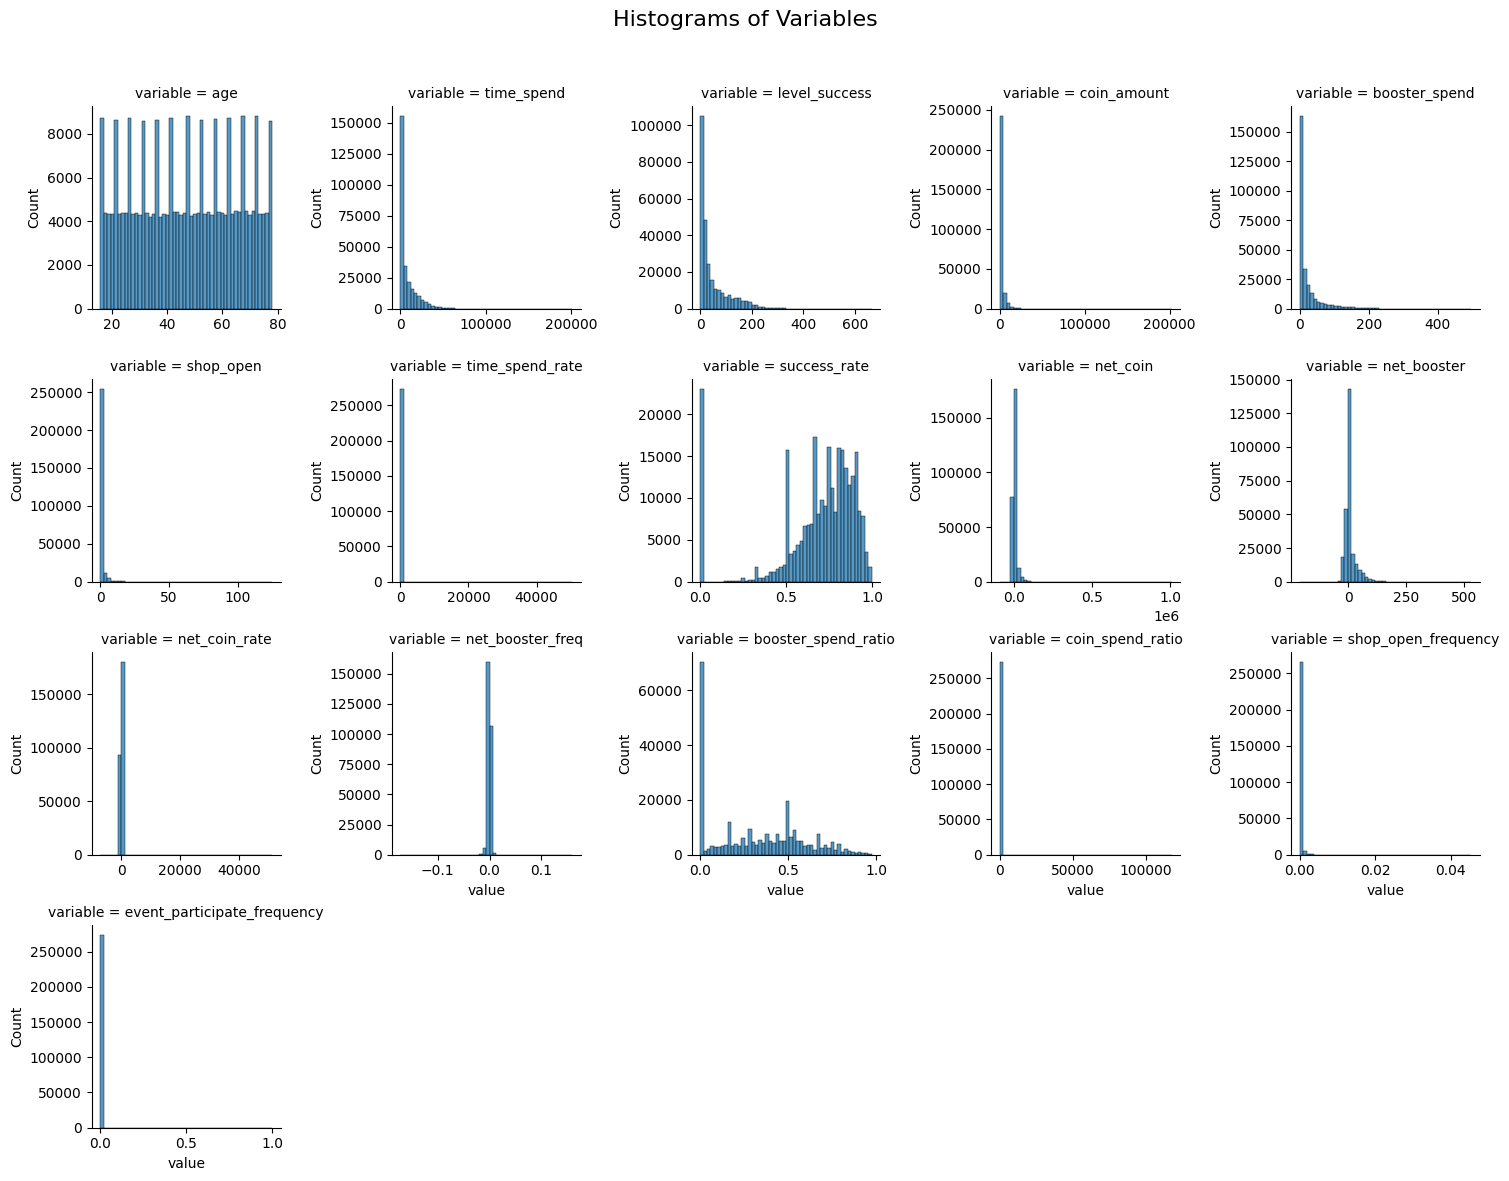

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from ml_utils import plot_histograms
#X_train.drop(columns=one_hot_encoded_columns).hist(figsize=(20,20), bins=50)
plot_histograms(X_train.drop(columns=one_hot_encoded_columns))

### Design Matrix Transformation

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

"""
Comparing different transformers to decide which one to use
"""

scalers = {
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler(),
    "PowerTransformer": PowerTransformer(),
    "QuantileTransformer": QuantileTransformer(output_distribution="normal")
}

rocauc_scores = {}

for name, scaler in scalers.items():
    pipeline = Pipeline([
        ('scaler', scaler),
        ('logreg', LogisticRegression(max_iter=1000))
    ])
    
    scores = cross_val_score(pipeline, X_train.drop(columns=one_hot_encoded_columns), y_train, cv=5, scoring="roc_auc")
    rocauc_scores[name] = scores
    print(f"{name}: Mean ROC AUC = {np.mean(scores):.3f} (Std: {np.std(scores):.3f})")

del pipeline, scores, scaler

rocauc_scores

StandardScaler: Mean ROC AUC = 0.790 (Std: 0.004)
RobustScaler: Mean ROC AUC = 0.790 (Std: 0.004)
PowerTransformer: Mean ROC AUC = 0.811 (Std: 0.004)
QuantileTransformer: Mean ROC AUC = 0.805 (Std: 0.004)


{'StandardScaler': array([0.7878118 , 0.79293489, 0.78717725, 0.79662202, 0.78738618]),
 'RobustScaler': array([0.78796839, 0.7928616 , 0.78726732, 0.79677202, 0.78754733]),
 'PowerTransformer': array([0.80855245, 0.81243698, 0.80868385, 0.81928478, 0.80781161]),
 'QuantileTransformer': array([0.8015382 , 0.8059777 , 0.80178698, 0.81299341, 0.8016359 ])}

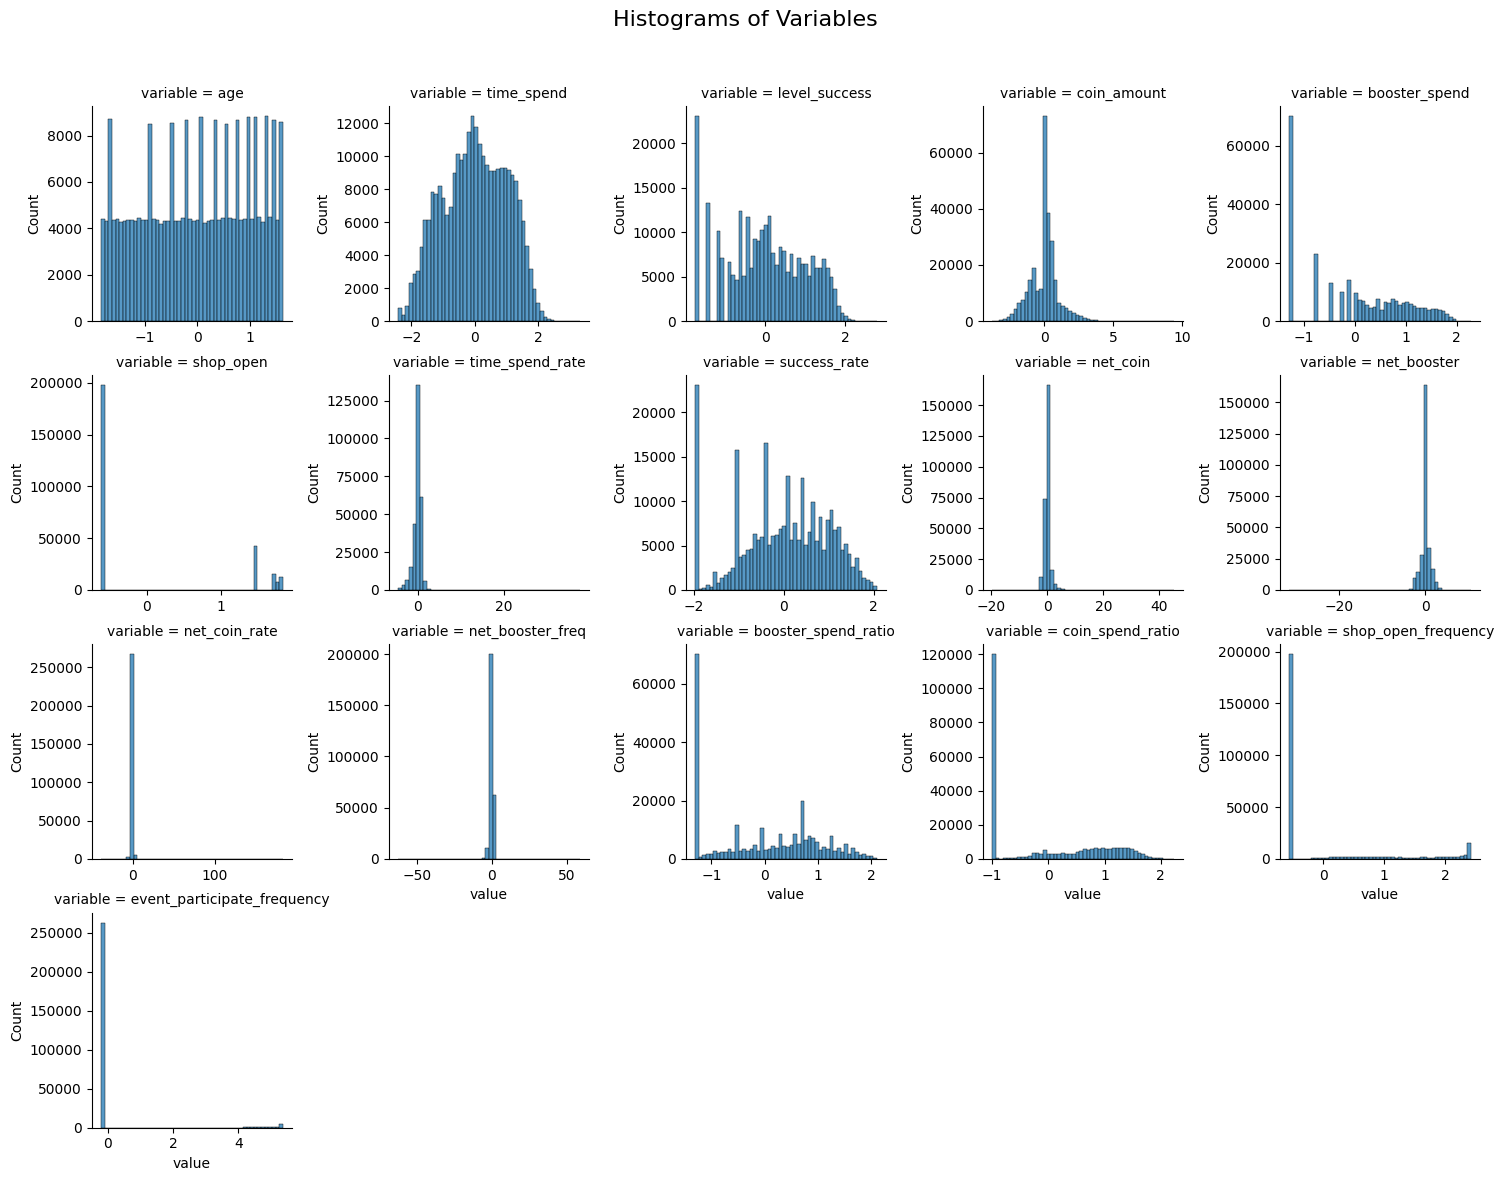

In [ ]:
"""
Pt is the best, so we will use it
"""

pt = PowerTransformer()
X_train_scaled = pt.fit_transform(X_train.drop(columns=one_hot_encoded_columns))
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.drop(columns=one_hot_encoded_columns).columns, index=X_train.index)
X_test_scaled = pt.transform(X_test.drop(columns=one_hot_encoded_columns))
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.drop(columns=one_hot_encoded_columns).columns, index=X_test.index)

plot_histograms(X_train_scaled)


### Target and Features Interactions

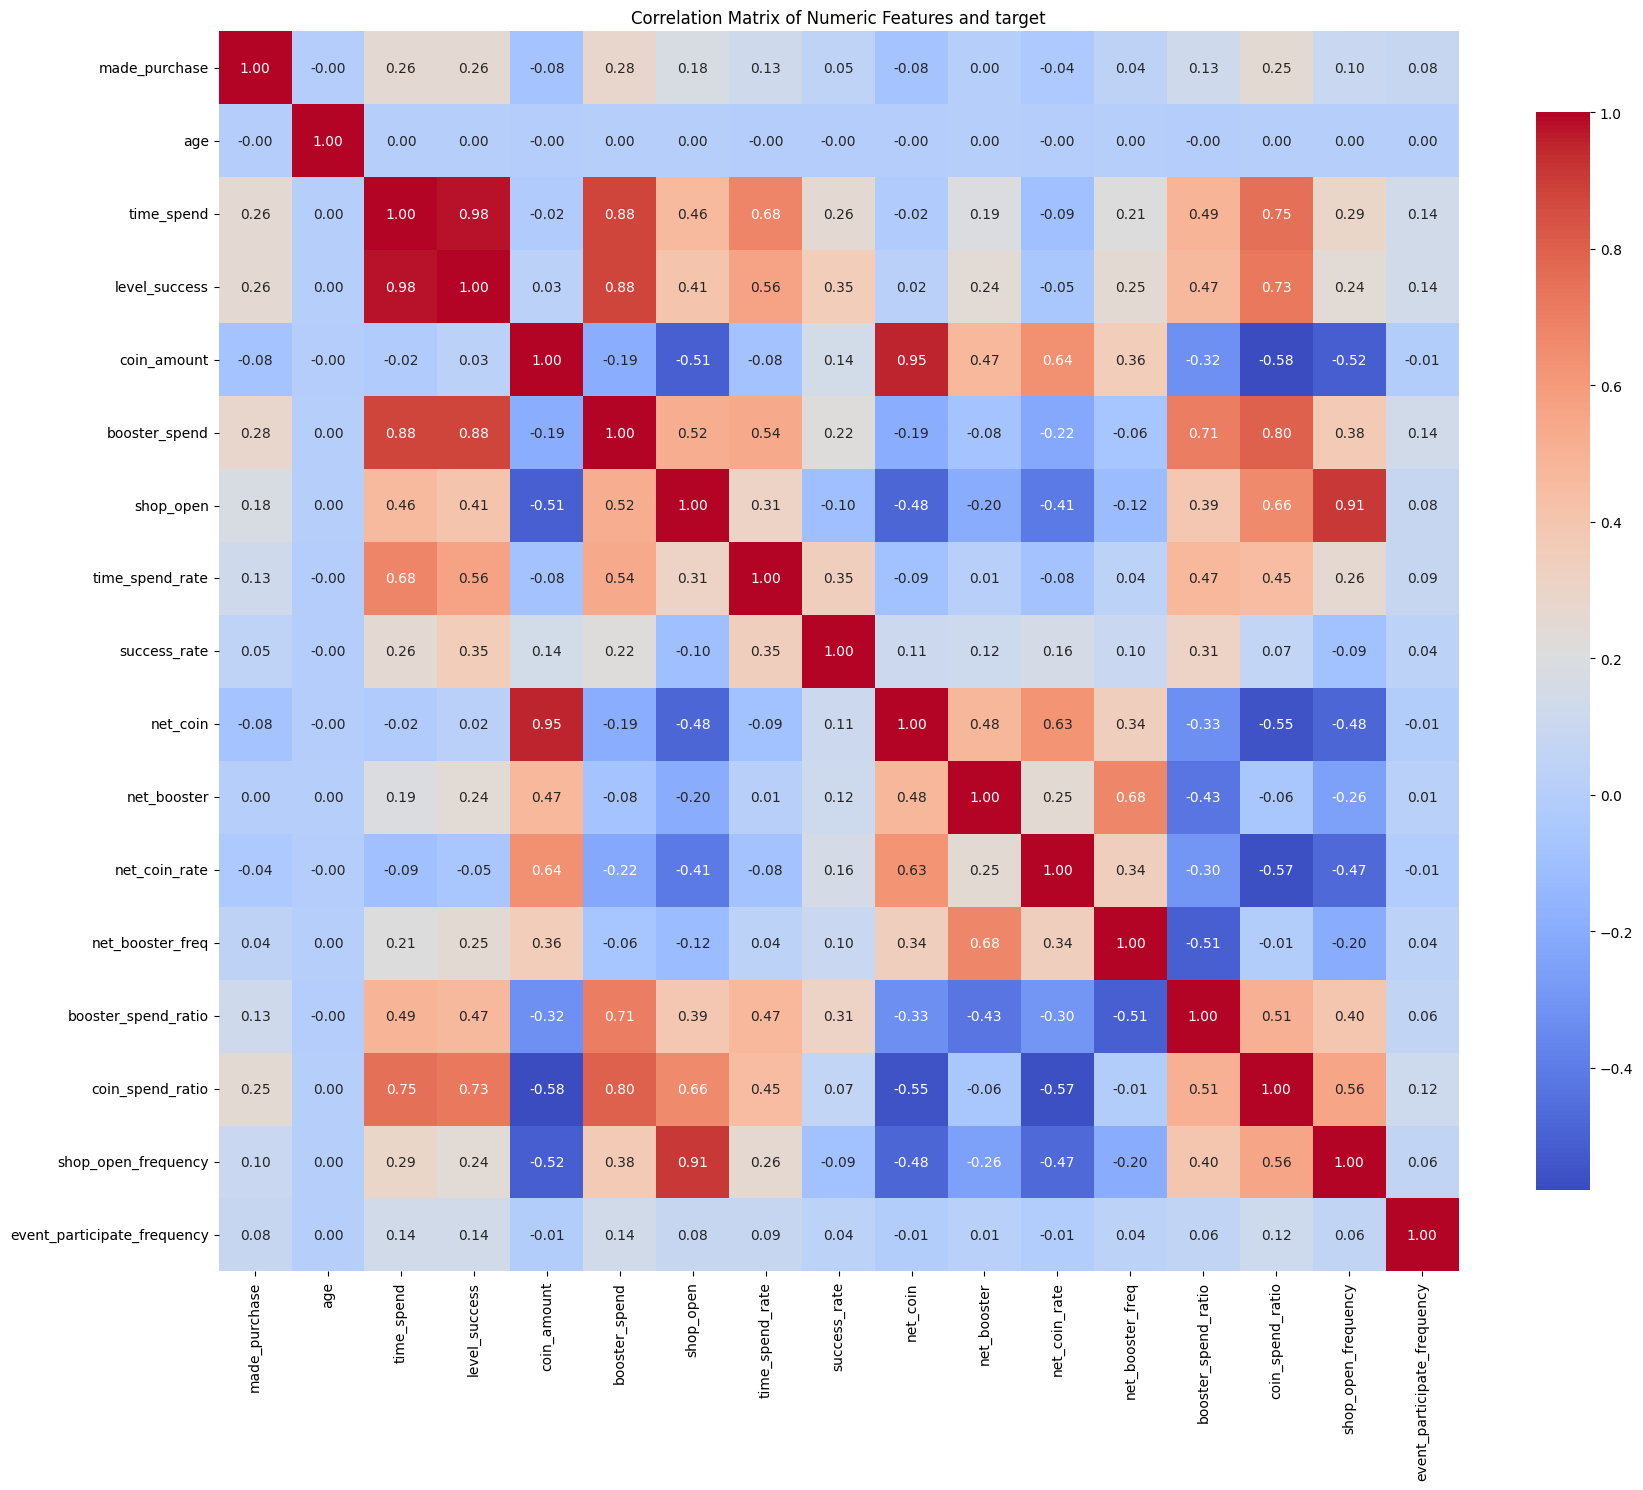

In [ ]:
### correlation matrix between features
import seaborn as sns
import matplotlib.pyplot as plt

corr = pd.concat([y_train, X_train_scaled],axis=1).corr()
plt.figure(figsize=(20,20))
plt.title("Correlation Matrix of Numeric Features and target")
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .7})
plt.show()


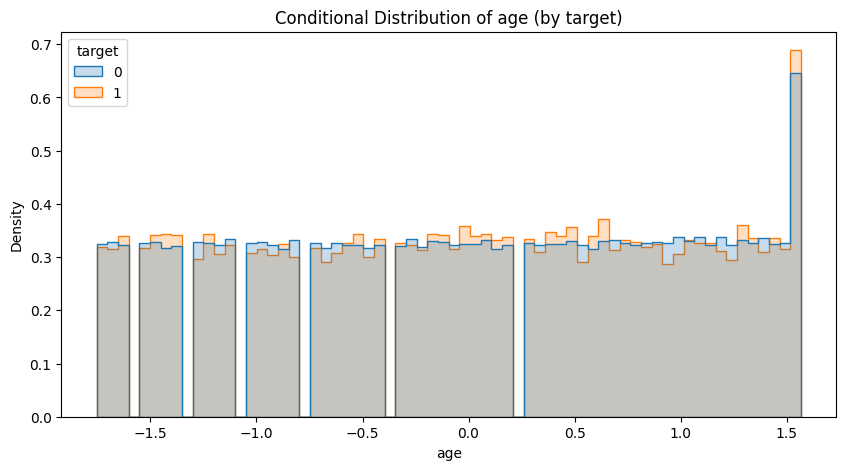

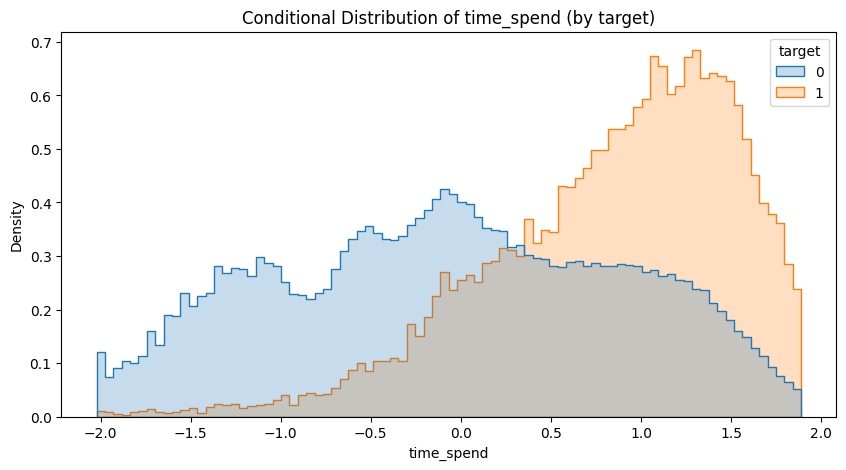

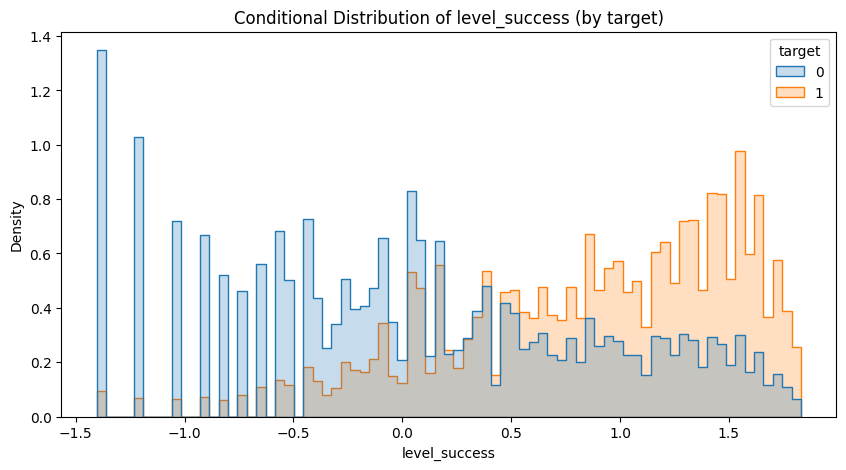

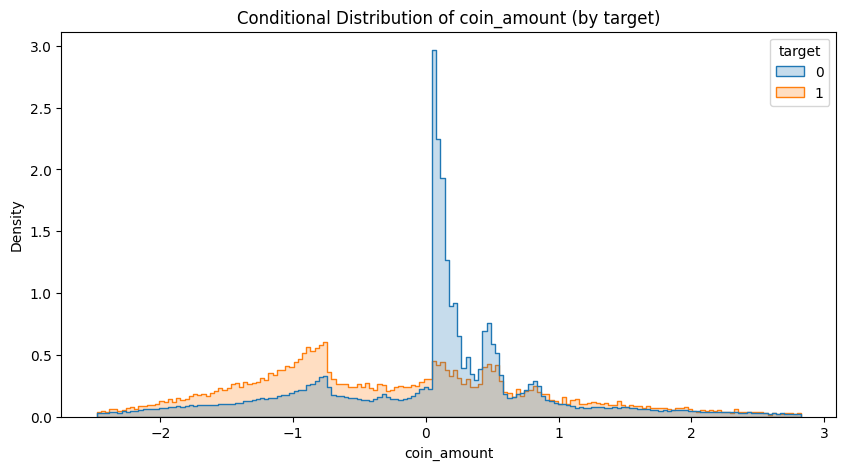

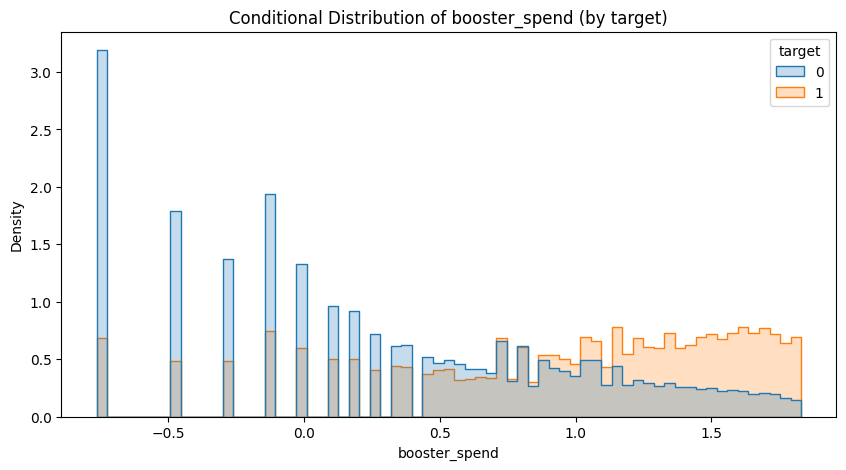

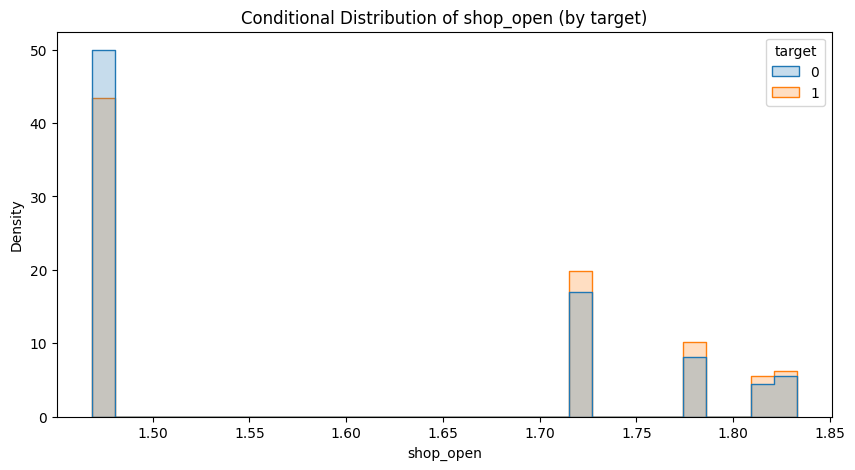

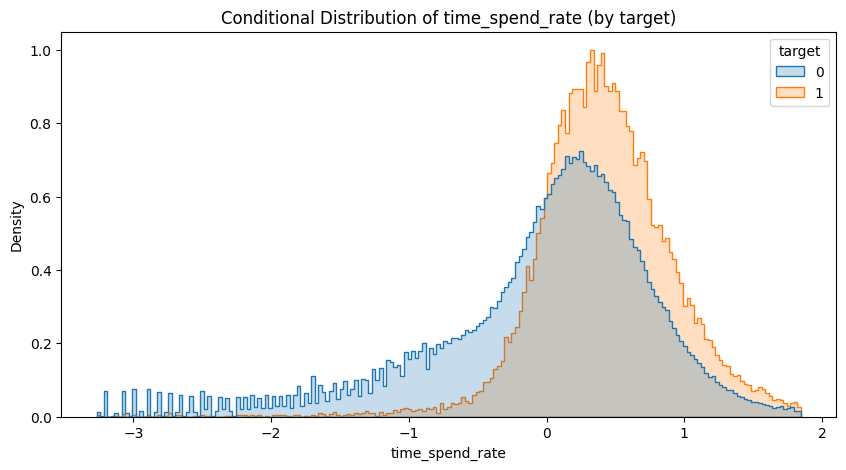

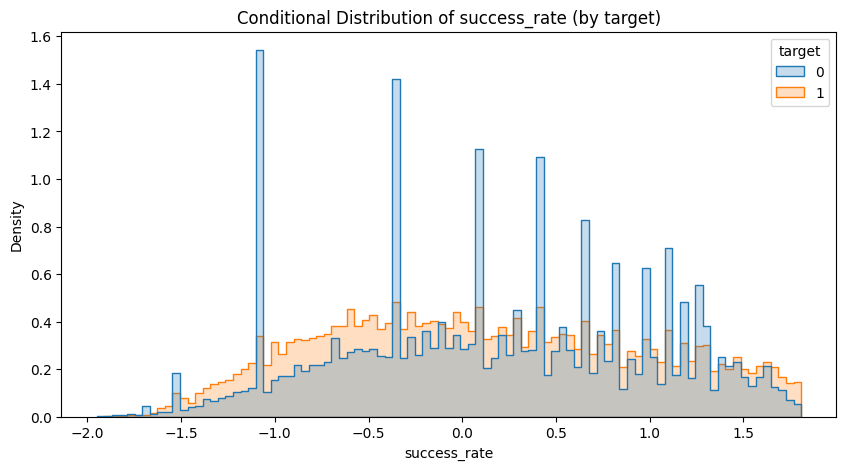

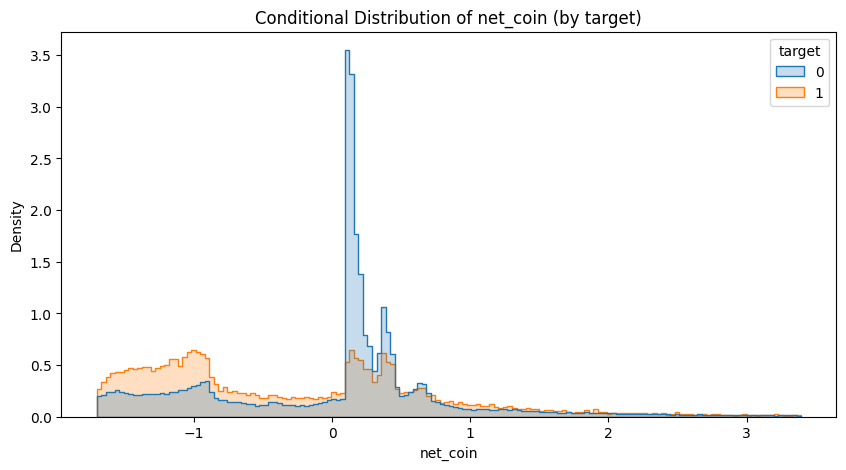

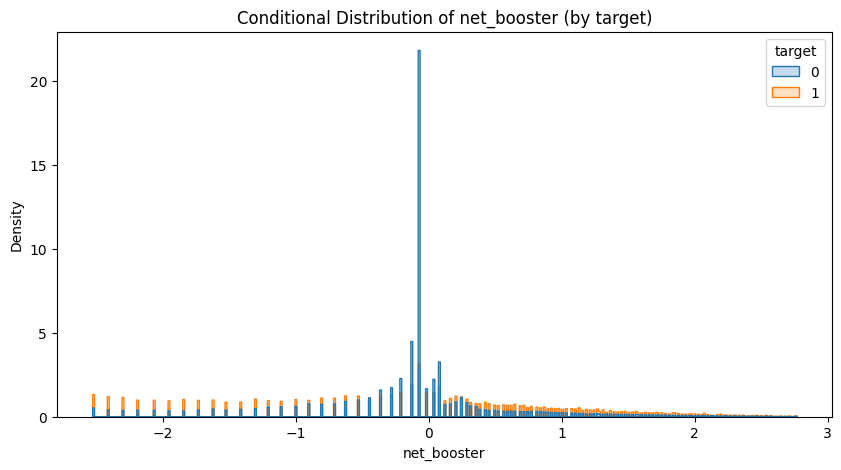

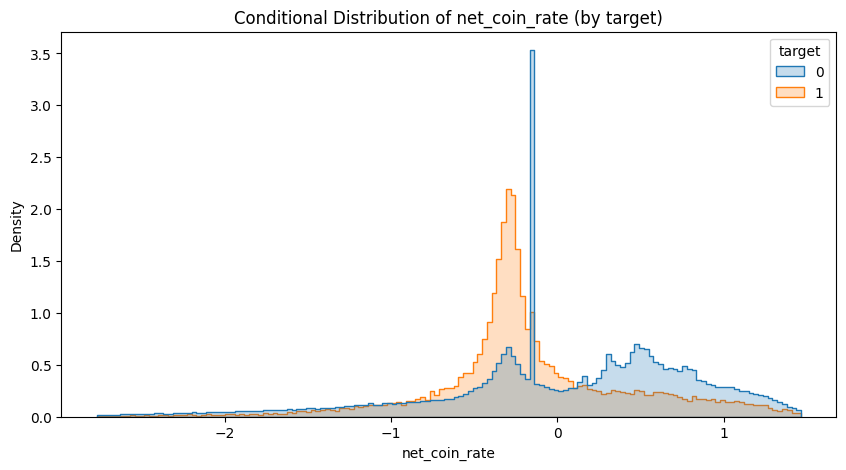

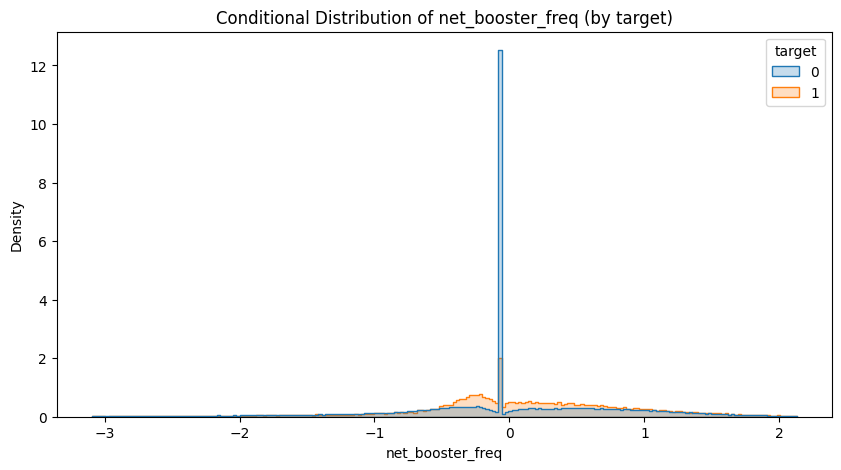

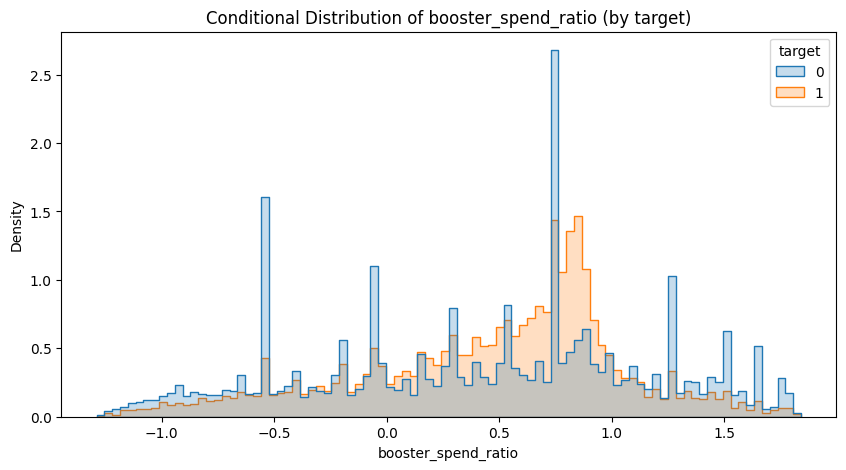

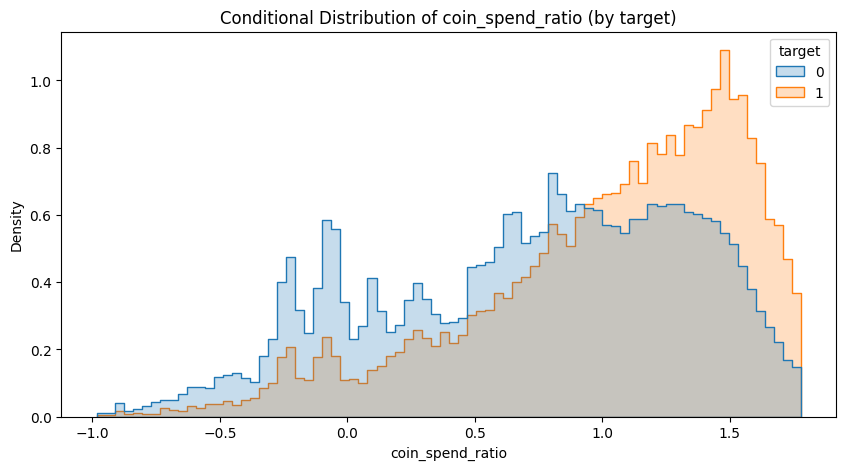

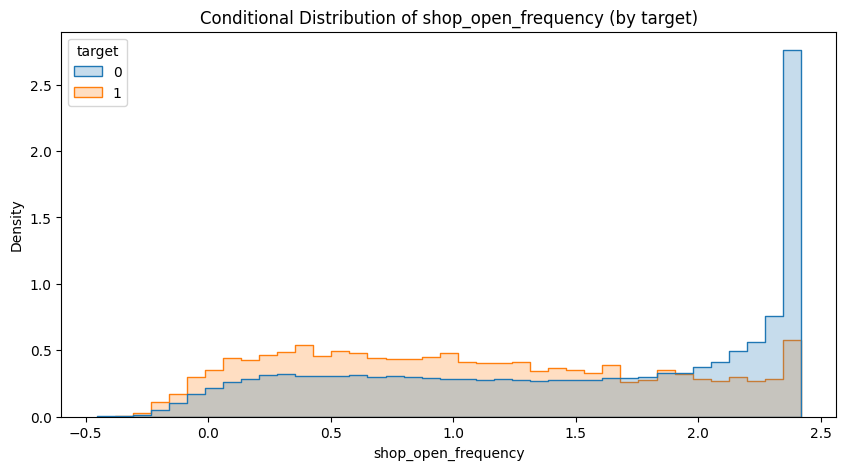

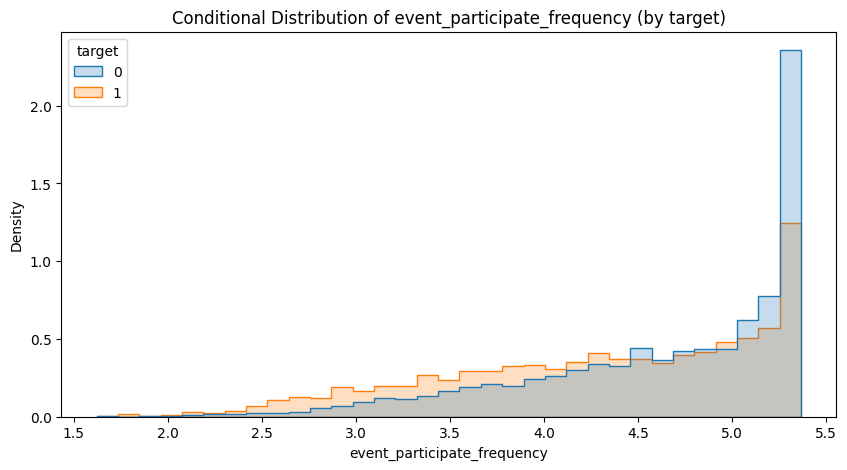

In [ ]:
from ml_utils import plot_conditional_distributions
plot_conditional_distributions(X_train_scaled, y_train, min_quantile=0.01)

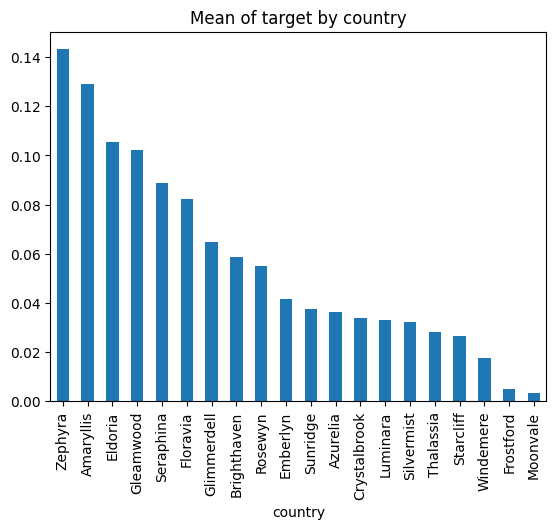

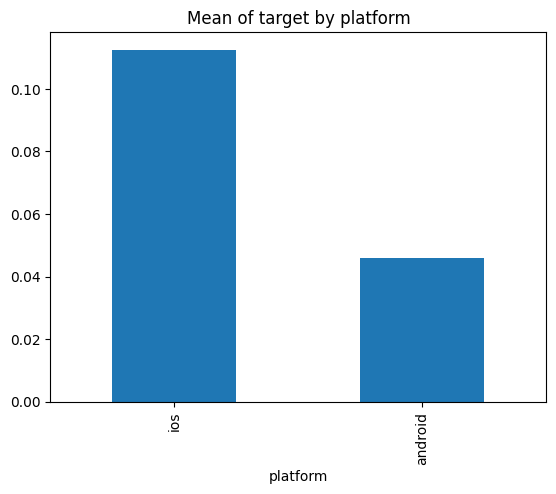

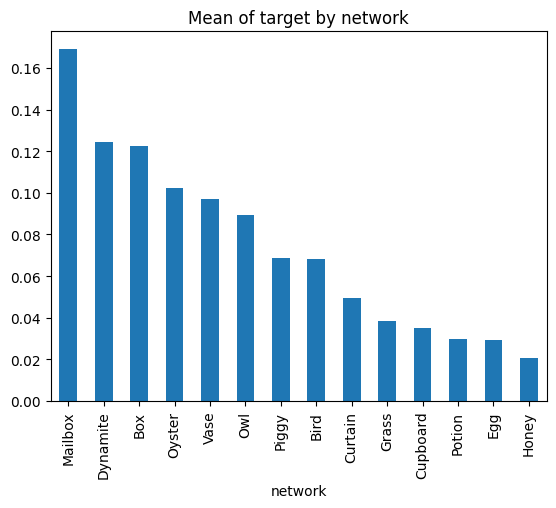

In [ ]:
y_train.groupby(df['country'].loc[y_train.index]).mean().sort_values(ascending=False).plot(kind='bar', title = 'Mean of target by country')
plt.show()
y_train.groupby(df['platform'].loc[y_train.index]).mean().sort_values(ascending=False).plot(kind='bar', title = 'Mean of target by platform')
plt.show()
y_train.groupby(df['network'].loc[y_train.index]).mean().sort_values(ascending=False).plot(kind='bar', title = 'Mean of target by network')
plt.show()

### Machine Learning Models

In [ ]:
### merging one hot encoded columns with scaled data
X_train_scaled = pd.concat([X_train[one_hot_encoded_columns],X_train_scaled], axis=1)
X_test_scaled = pd.concat([X_test[one_hot_encoded_columns],X_test_scaled], axis=1)
print(X_train_scaled.shape, X_test_scaled.shape)

(274015, 90) (68504, 90)


In [ ]:
"""
data is highly imbalanced so we consider using sample weights during fir and recalibrate the model later,
we will use the inverse of the class frequency as sample weights, It seems a logical strategy but to see if it works,
we will compare the results with and without sample weights with a simple logistic regression model
"""

print(y_train.value_counts(normalize=True))

made_purchase
0    0.92157
1    0.07843
Name: proportion, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import uniform

# Define hyperparameter grid.
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]  
}

# ---------- Unweighted Elastic-Net Logistic Regression with RandomizedSearchCV ----------
elastic = LogisticRegression(
    penalty='elasticnet',
    solver='saga',  # saga solver supports elasticnet penalty
    max_iter=1000,
    random_state=42
)

random_search_elastic = RandomizedSearchCV(
    estimator=elastic,
    param_distributions=param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit unweighted model.
random_search_elastic.fit(X_train_scaled, y_train)
print("Unweighted Elastic-Net Logistic Regression - Best ROC AUC:", random_search_elastic.best_score_)
print("Best Hyperparameters (Unweighted):", random_search_elastic.best_params_)

best_elastic = random_search_elastic.best_estimator_

# Predict probabilities on test set.
y_proba_elastic = best_elastic.predict_proba(X_test_scaled)[:, 1]
print("\nUnweighted Elastic-Net Logistic Regression (Uncalibrated)")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_elastic):.3f}")
print(classification_report(y_test, y_proba_elastic > 0.5))

# Calibrate the unweighted model with ensemble=True.
calibrated_elastic = CalibratedClassifierCV(
    estimator=best_elastic,
    cv=5,
    method="isotonic",
    n_jobs=-1,
    ensemble=True
)
calibrated_elastic.fit(X_train_scaled, y_train)
y_proba_elastic_cal = calibrated_elastic.predict_proba(X_test_scaled)[:, 1]
print("\nUnweighted Elastic-Net Logistic Regression (Calibrated)")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_elastic_cal):.3f}")
print(classification_report(y_test, y_proba_elastic_cal > 0.5))

# ---------- Weighted Elastic-Net Logistic Regression with RandomizedSearchCV ----------
# Compute sample weights based on inverse class frequency.
sample_weights = y_train.map({
    0: 1 / y_train.value_counts(normalize=True)[0],
    1: 1 / y_train.value_counts(normalize=True)[1]
})

elastic_weighted = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=1000,
    random_state=42
)

random_search_elastic_weighted = RandomizedSearchCV(
    estimator=elastic_weighted,
    param_distributions=param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit weighted model using sample weights.
random_search_elastic_weighted.fit(X_train_scaled, y_train, sample_weight=sample_weights)
print("\nWeighted Elastic-Net Logistic Regression - Best ROC AUC:", random_search_elastic_weighted.best_score_)
print("Best Hyperparameters (Weighted):", random_search_elastic_weighted.best_params_)

best_elastic_weighted = random_search_elastic_weighted.best_estimator_

# Predict probabilities.
y_proba_elastic_weighted = best_elastic_weighted.predict_proba(X_test_scaled)[:, 1]
print("\nWeighted Elastic-Net Logistic Regression (Uncalibrated)")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_elastic_weighted):.3f}")
print(classification_report(y_test, y_proba_elastic_weighted > 0.5))

# Calibrate the weighted model with ensemble=True.
calibrated_elastic_weighted = CalibratedClassifierCV(
    estimator=best_elastic_weighted,
    cv=3,
    method='isotonic',
    n_jobs=-1,
    ensemble=True
)
calibrated_elastic_weighted.fit(X_train_scaled, y_train)
y_proba_elastic_weighted_cal = calibrated_elastic_weighted.predict_proba(X_test_scaled)[:, 1]
print("\nWeighted Elastic-Net Logistic Regression (Calibrated)")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_elastic_weighted_cal):.3f}")
print(classification_report(y_test, y_proba_elastic_weighted_cal > 0.5))

# Combine predicted probabilities into a DataFrame.
lr_probas = pd.DataFrame({
    "ElasticNet_Uncalibrated": y_proba_elastic,
    "ElasticNet_Calibrated": y_proba_elastic_cal,
    "ElasticNet_Weighted_Uncalibrated": y_proba_elastic_weighted,
    "ElasticNet_Weighted_Calibrated": y_proba_elastic_weighted_cal
})

# ---------- Plotting the Distribution of Predicted Probabilities ----------
plt.figure(figsize=(12, 8))
sns.histplot(y_proba_elastic, color="blue", kde=True, label="ElasticNet Uncalibrated", stat="density", bins=25, alpha=0.6)
sns.histplot(y_proba_elastic_cal, color="cyan", kde=True, label="ElasticNet Calibrated", stat="density", bins=25, alpha=0.6)
sns.histplot(y_proba_elastic_weighted, color="red", kde=True, label="ElasticNet Weighted Uncalibrated", stat="density", bins=25, alpha=0.6)
sns.histplot(y_proba_elastic_weighted_cal, color="orange", kde=True, label="ElasticNet Weighted Calibrated", stat="density", bins=25, alpha=0.6)

plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Distribution of Predicted Probabilities\nElastic-Net Logistic Regression")
plt.legend()
plt.show()


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/yusuf/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yusuf/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yusuf/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yusuf/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yusuf/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yusuf/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Convergen

In [ ]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

# Define hyperparameter grid.
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Initialize the base XGBoost classifier.
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

##############################
# 1. Unweighted XGBoost Model (Uncalibrated)
##############################

random_search_xgb_unweighted = RandomizedSearchCV(
    estimator=elastic,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_xgb_unweighted.fit(X_train_scaled, y_train)
print("Unweighted Model - Best Parameters:", random_search_xgb_unweighted.best_params_)
print("Unweighted Model - Best CV ROC AUC Score:", random_search_xgb_unweighted.best_score_)

# Predictions for unweighted uncalibrated model.
y_pred_unweighted = random_search_xgb_unweighted.predict(X_test_scaled)
y_proba_unweighted = random_search_xgb_unweighted.predict_proba(X_test_scaled)[:, 1]
print("\nUnweighted XGBoost (Uncalibrated) Classification Report:")
print(classification_report(y_test, y_pred_unweighted))
print("Unweighted XGBoost (Uncalibrated) Test ROC AUC Score:", roc_auc_score(y_test, y_proba_unweighted))

##############################
# 2. Unweighted XGBoost Model (Calibrated)
##############################

calibrated_xgb_unweighted = CalibratedClassifierCV(
    estimator=random_search_xgb_unweighted.best_estimator_,
    cv=5,
    method='isotonic',  # or 'isotonic'
    n_jobs=-1,
    ensemble=True
)
calibrated_xgb_unweighted.fit(X_train_scaled, y_train)
y_pred_unweighted_cal = calibrated_xgb_unweighted.predict(X_test_scaled)
y_proba_unweighted_cal = calibrated_xgb_unweighted.predict_proba(X_test_scaled)[:, 1]
print("\nUnweighted XGBoost (Calibrated) Classification Report:")
print(classification_report(y_test, y_pred_unweighted_cal))
print("Unweighted XGBoost (Calibrated) Test ROC AUC Score:", roc_auc_score(y_test, y_proba_unweighted_cal))

##############################
# 3. Weighted XGBoost Model (Uncalibrated)
##############################

# Compute sample weights based on inverse class frequency.
sample_weights = y_train.map({
    0: 1 / y_train.value_counts(normalize=True)[0],
    1: 1 / y_train.value_counts(normalize=True)[1]
})

# Use a new GridSearchCV instance for weighted training.
random_search_xgb_weighted = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)
random_search_xgb_weighted.fit(X_train_scaled, y_train, sample_weight=sample_weights)
print("\nWeighted Model - Best Parameters:", random_search_xgb_weighted.best_params_)
print("Weighted Model - Best CV ROC AUC Score:", random_search_xgb_weighted.best_score_)

# Predictions for weighted uncalibrated model.
y_pred_weighted = random_search_xgb_weighted.predict(X_test_scaled)
y_proba_weighted = random_search_xgb_weighted.predict_proba(X_test_scaled)[:, 1]
print("\nWeighted XGBoost (Uncalibrated) Classification Report:")
print(classification_report(y_test, y_pred_weighted))
print("Weighted XGBoost (Uncalibrated) Test ROC AUC Score:", roc_auc_score(y_test, y_proba_weighted))

##############################
# 4. Weighted XGBoost Model (Calibrated)
##############################

calibrated_xgb_weighted = CalibratedClassifierCV(
    estimator=random_search_xgb_weighted.best_estimator_,
    cv=5,
    method='isotonic',  # or 'isotonic'
    n_jobs=-1,
    ensemble=True
)
calibrated_xgb_weighted.fit(X_train_scaled, y_train)
y_pred_weighted_cal = calibrated_xgb_weighted.predict(X_test_scaled)
y_proba_weighted_cal = calibrated_xgb_weighted.predict_proba(X_test_scaled)[:, 1]
print("\nWeighted XGBoost (Calibrated) Classification Report:")
print(classification_report(y_test, y_pred_weighted_cal))
print("Weighted XGBoost (Calibrated) Test ROC AUC Score:", roc_auc_score(y_test, y_proba_weighted_cal))



xgb_probas = pd.DataFrame({
    "XGB_Unweighted_Uncalibrated": y_proba_unweighted,
    "XGB_Unweighted_Calibrated": y_proba_unweighted_cal,
    "XGB_Weighted_Uncalibrated": y_proba_weighted,
    "XGB_Weighted_Calibrated": y_proba_weighted_cal
})

print("\nCombined predicted probabilities:")
print(xgb_probas.head())


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Unweighted RandomForest - Best ROC AUC: 0.8570163992088101
Best Hyperparameters (Unweighted): {'n_estimators': 200, 'min_samples_split': 20, 'max_depth': 20}
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Weighted RandomForest - Best ROC AUC: 0.8541680473243115
Best Hyperparameters (Weighted): {'n_estimators': 200, 'min_samples_split': 20, 'max_depth': 20}

Unweighted RandomForest (Uncalibrated)
ROC AUC: 0.857
Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     63137
           1       0.70      0.10      0.18      5367

    accuracy                           0.93     68504
   macro avg       0.81      0.55      0.57     68504
weighted avg       0.91      0.93      0.90     68504


Unweighted RandomForest (Calibrated)
ROC AUC: 0.855
Classification Report (threshold=0.5):
              precision    recall  f1-score   suppor

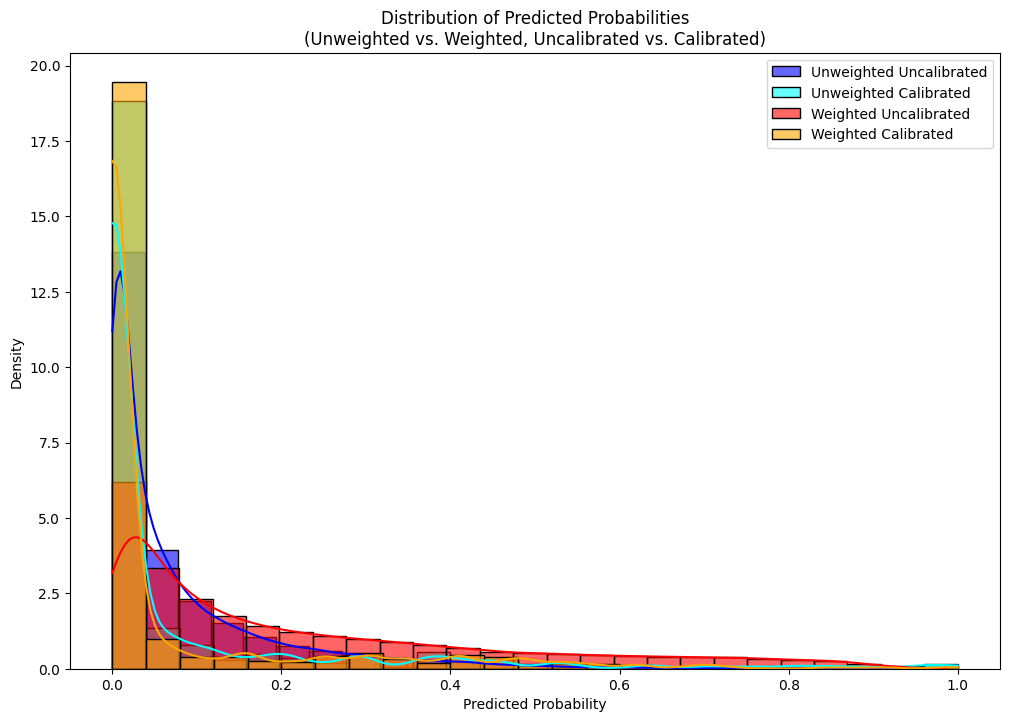

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

# Define hyperparameter grid for SVC with RBF kernel.
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Note: Set probability=True to enable probability estimates.
svc = SVC(kernel='rbf', probability=True, random_state=42)

##############################
# 1. Unweighted SVC Model (Uncalibrated)
##############################
grid_svc_unweighted = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_svc_unweighted.fit(X_train_scaled, y_train)
print("Unweighted SVC - Best Parameters:", grid_svc_unweighted.best_params_)
print("Unweighted SVC - Best CV ROC AUC Score:", grid_svc_unweighted.best_score_)

# Predictions for unweighted uncalibrated model.
y_pred_unweighted = grid_svc_unweighted.predict(X_test_scaled)
y_proba_unweighted = grid_svc_unweighted.predict_proba(X_test_scaled)[:, 1]
print("\nUnweighted SVC (Uncalibrated) Classification Report:")
print(classification_report(y_test, y_pred_unweighted))
print("Unweighted SVC (Uncalibrated) Test ROC AUC Score:", roc_auc_score(y_test, y_proba_unweighted))

##############################
# 2. Unweighted SVC Model (Calibrated)
##############################
calibrated_svc_unweighted = CalibratedClassifierCV(
    estimator=grid_svc_unweighted.best_estimator_,
    cv=5,
    method='isotonic',  
    n_jobs=-1,
    ensemble=True
)
calibrated_svc_unweighted.fit(X_train_scaled, y_train)
y_pred_unweighted_cal = calibrated_svc_unweighted.predict(X_test_scaled)
y_proba_unweighted_cal = calibrated_svc_unweighted.predict_proba(X_test_scaled)[:, 1]
print("\nUnweighted SVC (Calibrated) Classification Report:")
print(classification_report(y_test, y_pred_unweighted_cal))
print("Unweighted SVC (Calibrated) Test ROC AUC Score:", roc_auc_score(y_test, y_proba_unweighted_cal))

##############################
# 3. Weighted SVC Model (Uncalibrated)
##############################
# Compute sample weights based on inverse class frequency.
sample_weights = y_train.map({
    0: 1 / y_train.value_counts(normalize=True)[0],
    1: 1 / y_train.value_counts(normalize=True)[1]
})

grid_svc_weighted = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid_svc_weighted.fit(X_train_scaled, y_train, sample_weight=sample_weights)
print("\nWeighted SVC - Best Parameters:", grid_svc_weighted.best_params_)
print("Weighted SVC - Best CV ROC AUC Score:", grid_svc_weighted.best_score_)

# Predictions for weighted uncalibrated model.
y_pred_weighted = grid_svc_weighted.predict(X_test_scaled)
y_proba_weighted = grid_svc_weighted.predict_proba(X_test_scaled)[:, 1]
print("\nWeighted SVC (Uncalibrated) Classification Report:")
print(classification_report(y_test, y_pred_weighted))
print("Weighted SVC (Uncalibrated) Test ROC AUC Score:", roc_auc_score(y_test, y_proba_weighted))

##############################
# 4. Weighted SVC Model (Calibrated)
##############################
calibrated_svc_weighted = CalibratedClassifierCV(
    estimator=grid_svc_weighted.best_estimator_,
    cv=5,
    method='isotonic',  
    n_jobs=-1,
    ensemble=True
)
calibrated_svc_weighted.fit(X_train_scaled, y_train)
y_pred_weighted_cal = calibrated_svc_weighted.predict(X_test_scaled)
y_proba_weighted_cal = calibrated_svc_weighted.predict_proba(X_test_scaled)[:, 1]
print("\nWeighted SVC (Calibrated) Classification Report:")
print(classification_report(y_test, y_pred_weighted_cal))
print("Weighted SVC (Calibrated) Test ROC AUC Score:", roc_auc_score(y_test, y_proba_weighted_cal))

##############################
# Optional: Combine predicted probabilities for comparison.
##############################
svc_probas = pd.DataFrame({
    "SVC_Unweighted_Uncalibrated": y_proba_unweighted,
    "SVC_Unweighted_Calibrated": y_proba_unweighted_cal,
    "SVC_Weighted_Uncalibrated": y_proba_weighted,
    "SVC_Weighted_Calibrated": y_proba_weighted_cal
})

print("\nCombined predicted probabilities:")
print(svc_probas.head())
